<a href="https://colab.research.google.com/github/michaellopes16/DataScience/blob/main/Projeto_AM_Segunda_quest%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import math
import random
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

import scipy.stats 
from sklearn.metrics import coverage_error

import matplotlib.pyplot as plt
#sns.set_theme(style="darkgrid")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

sns.dark_palette("#69d", reverse=True, as_cmap=True)
from sklearn.decomposition import PCA
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importação de dados e definição dos principais parâmetros

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AM/data_banknote_authentication.txt", sep=",", header=None, names=["variance", "skewness", "curtosis","entropy","class"])
print(df)

X = df[['variance', 'skewness', 'curtosis','entropy']]
y = df[['class']]

N = 50

      variance  skewness  curtosis  entropy  class
0      3.62160   8.66610   -2.8073 -0.44699      0
1      4.54590   8.16740   -2.4586 -1.46210      0
2      3.86600  -2.63830    1.9242  0.10645      0
3      3.45660   9.52280   -4.0112 -3.59440      0
4      0.32924  -4.45520    4.5718 -0.98880      0
...        ...       ...       ...      ...    ...
1367   0.40614   1.34920   -1.4501 -0.55949      1
1368  -1.38870  -4.87730    6.4774  0.34179      1
1369  -3.75030 -13.45860   17.5932 -2.77710      1
1370  -3.56370  -8.38270   12.3930 -1.28230      1
1371  -2.54190  -0.65804    2.6842  1.19520      1

[1372 rows x 5 columns]


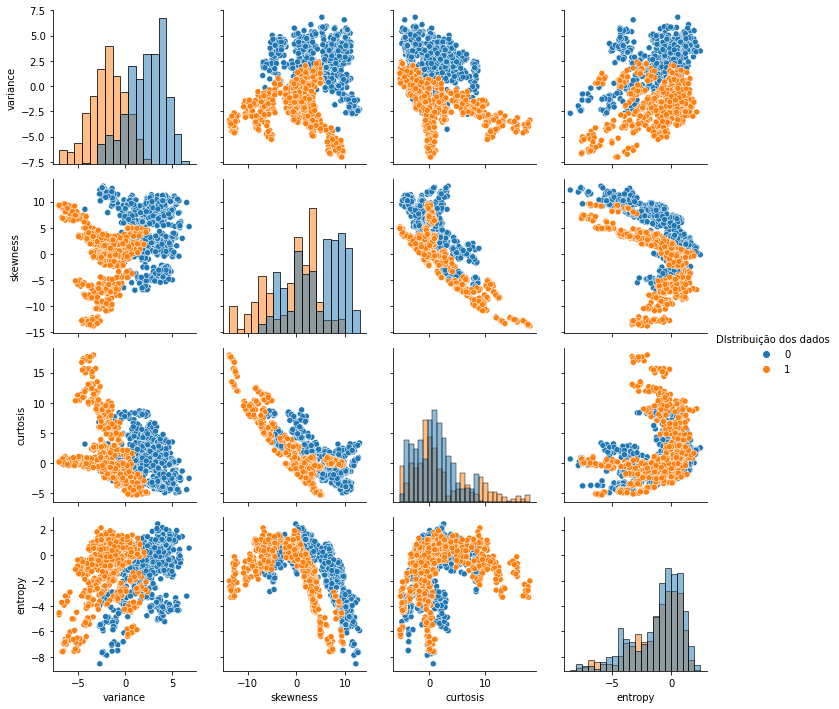

In [ ]:
df['class']=pd.Categorical(df['class'])
my_class =df['class'].cat.codes


g = sns.PairGrid(df, hue="class")
g.map_diag(sns.histplot,color=my_class)
g.map_offdiag(sns.scatterplot)
g.add_legend(title="DIstribuição dos dados", adjust_subtitles=True)

Normalização dos dados. Todos os valores ficarão entre 0 e 1

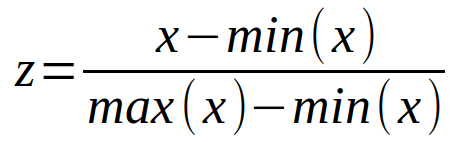

In [ ]:
print(my_class)

0       0
1       0
2       0
3       0
4       0
       ..
1367    1
1368    1
1369    1
1370    1
1371    1
Length: 1372, dtype: int8


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
df2 = pd.DataFrame(x_scaled)
df_normalized = df2.copy()
df_normalized['4'] = my_class
print(df_normalized)

             0         1         2         3  4
0     0.769004  0.839643  0.106783  0.736628  0
1     0.835659  0.820982  0.121804  0.644326  0
2     0.786629  0.416648  0.310608  0.786951  0
3     0.757105  0.871699  0.054921  0.450440  0
4     0.531578  0.348662  0.424662  0.687362  0
...        ...       ...       ...       ... ..
1367  0.537124  0.565855  0.165249  0.726398  1
1368  0.407690  0.332868  0.506753  0.808350  1
1369  0.237385  0.011768  0.985603  0.524755  1
1370  0.250842  0.201701  0.761587  0.660675  1
1371  0.324528  0.490747  0.343348  0.885949  1

[1372 rows x 5 columns]


In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df2)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2','PC3'])

Text(0.5, 0.92, 'PCA on the iris data set')

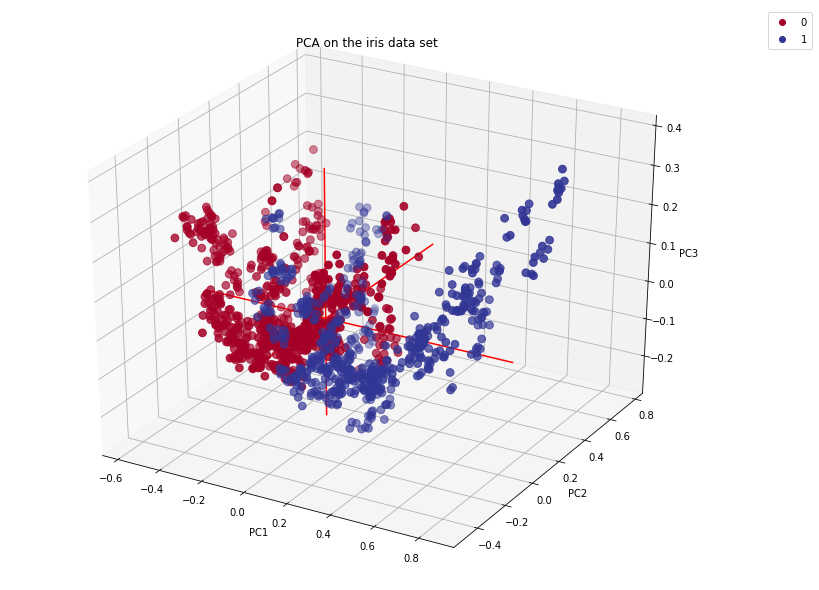

In [ ]:
# axes instance

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

# plot
sc = ax.scatter(principalDf['PC1'], principalDf['PC2'], principalDf['PC3'], s=60, c=my_class, marker='o', cmap="RdYlBu")

# make simple, bare axis lines through space:
xAxisLine = ((min(principalDf['PC1']), max(principalDf['PC1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(principalDf['PC2']), max(principalDf['PC2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(principalDf['PC3']), max(principalDf['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# label the axes
#ax.view_init(350, 150)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the iris data set")



# Considere novamente os dados "banknote authentication Data Set"

a) Use validação cruzada estratificada “10-folds” para avaliar e comparar os classificadores combinados descritos abaixo. Quando necessario, retire do conjunto de aprendizagem, um conjunto de validação (20%) para fazer ajuste de parametros e depois treine o modelo novamente com os conjuntos aprendizagem + validação. Use amostragem estratificada.

b) Obtenha uma estimativa pontual e um intervalo de confiança para cada metrica de avaliaa¸ão do classificador (Taxa de erro, precisão, cobertura, F-measure);

c) Usar o Friedman test (teste não parametrico) para comparar os classificadores

# StratifiedKFold

a) Use validação cruzada estratificada “10-folds” para avaliar e comparar os classificadores combinados descritos abaixo. Quando necessario, retire do conjunto de aprendizagem, um conjunto de validação (20%) para fazer ajuste de parametros e depois treine o modelo novamente com os conjuntos aprendizagem + validação. Use amostragem estratificada

In [ ]:
def trainAndValidate(model, with_val, x, y ,n_splits, random_state):
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    meanScoreValidation = []
    meanProbaValidation = []
    if (with_val):
        X_rest, X_test, y_rest, y_test  = train_test_split(x, y, test_size=0.2, train_size=0.8, stratify=y)
    else:
        X_rest = x
        y_rest = y
    for train_index, test_index in skf.split(X_rest, y_rest):
        X_train, X_val = X_rest[train_index], X_rest[test_index]
        y_train, y_val = y_rest.iloc[train_index], y_rest.iloc[test_index]
        model.fit(X_train, np.ravel(y_train))
        scoreValidation = model.predict(X_val)
        meanScoreValidation.append(accuracy_score(scoreValidation,y_val))
        if (not with_val):
            X_test = X_val
            y_test = y_val
    return  np.mean(meanScoreValidation), np.std(meanScoreValidation), scoreValidation, X_test, y_test, X_train, y_train
def runModel(model, n_times,with_val, x, y,  n_splits, random_state ):
    meanScoreValidation = []
    stdValidation = []
    y_preds = []
    X_test = []
    y_test = []
    X_train = []
    y_train = []
    for i in range(n_times):
        meanScore, std, y_pred , X_test, y_test, X_train, y_train =  trainAndValidate(model, with_val, x, y , n_splits, random_state)
        meanScoreValidation.append(meanScore) 
        stdValidation.append(std) 
        y_preds.append(y_pred)
    print(f"Média de validação: {np.mean(meanScoreValidation)}, desvio padrão:{np.mean(stdValidation)}")
    return np.mean(meanScoreValidation), np.mean(stdValidation), y_preds , meanScoreValidation, X_test, y_test, X_train, y_train

In [ ]:
def trainAndValidate2(model, with_val, x , y , n_splits, random_state):
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    meanScoreValidation = []
    if (with_val):
        X_rest, X_test, y_rest, y_test  = train_test_split(x, y, test_size=0.2, train_size=0.8, stratify=y)
    else:
        X_rest = x
        y_rest = y
    for train_index, test_index in skf.split(X_rest, y_rest):
        X_train, X_val = X_rest[train_index], X_rest[test_index]
        y_train, y_val = y_rest.iloc[train_index], y_rest.iloc[test_index]
        p = model.fit(X_train, X_val ,np.ravel(y_train))
        scoreValidation = model.predict(X_val, p)
        meanScoreValidation.append(accuracy_score(y_val, scoreValidation))
        
        if (not with_val):
            X_test = X_val
            y_test = y_val
    return  np.mean(meanScoreValidation), np.std(meanScoreValidation), scoreValidation, X_test, y_test, X_train, y_train
def runModel2(model, n_times,with_val, x, y,  n_splits, random_state):
    meanScoreValidation = []
    stdValidation = []
    y_preds = []
    X_test = []
    y_test = []
    X_train = []
    y_train = []
    for i in range(n_times):
        meanScore, std, y_pred , X_test, y_test, X_train, y_train =  trainAndValidate2(model, with_val, x, y, n_splits, random_state)
        meanScoreValidation.append(meanScore) 
        stdValidation.append(std) 
        y_preds.append(y_pred)
    print(f"Média de validação: {np.mean(meanScoreValidation)}, desvio padrão:{np.mean(stdValidation)}")
    return np.mean(meanScoreValidation), np.mean(stdValidation), y_preds , meanScoreValidation, X_test, y_test, X_train, y_train

# F-measure

b) Obtenha uma estimativa pontual e um intervalo de confiança para cada metrica de avaliaa¸ão do classificador (Taxa de erro, precisão, cobertura, F-measure);

In [ ]:
#precisionfloat (if average is not None) or array of float, shape = [n_unique_labels]
#recallfloat (if average is not None) or array of float, , shape = [n_unique_labels]
#fbeta_scorefloat (if average is not None) or array of float, shape = [n_unique_labels]
#supportNone (if average is not None) or array of int, shape = [n_unique_labels]
def getMetrics(y_true, y_pred):
    precision, recall, fbeta_score, support = precision_recall_fscore_support(y_true, y_pred, average='micro')
    f_measure = 2* ((precision*recall)/(precision+recall))
    return   print(f"Precision: {precision}, Recall: {recall}, Erro: {1-precision}, Support: {support}, F_Measure: {f_measure}")

In [ ]:
from scipy.stats import friedmanchisquare
def getFriedmanResult(scores_clas1, scores_clas2, scores_clas3,scores_clas4,scores_clas5, scores_clas6):
    stat, p = friedmanchisquare(scores_clas1, scores_clas2, scores_clas3,scores_clas4,scores_clas5, scores_clas6)
    print(f"Statistics={stat}, p={p}")
    alpha = 0.05
    if p > alpha:
        print('A um nível de significância de 0.05, para P > 0.001 recomenda-se aceitar H0')
    else:
        print('A um nível de significância de 0.05, para P << 0.001 recomenda-se rejeitar H0')
    return stat, p 

Classificador bayesiano gaussiano: considere a seguinte regra de decisão: afetar o exemplo xk à 2 p(xk|ωi)P(ωi) classe ωl se P(ωl|xk) = max (1 ≤ l ≤ 2) i=1 p(xk|ωr)P(ωr) r=1

a) Use a estimativa de maxima verossimilhança para P(ωi)

# Classificador bayesiano gaussiano (I)

In [ ]:
from scipy.stats import multivariate_normal

class NBNormalMultivariate:
    classes = None
    def __init__(self):
        a = None
        
    #Matriz de probabilidades
    def fit(self, X_train_NB, X_test_NB, y_train_NB):
        self.classes = np.unique(y_train_NB)
        p = pd.DataFrame(data=np.zeros((X_test_NB.shape[0], len(classes))), columns=self.classes)
        #Chances de pertencer a cada classe
        pc = np.zeros(len(classes))
        for i in np.arange(0, len(self.classes)):
            elements = tuple(np.where(y_train_NB == self.classes[i]))
            pc[i] = len(elements)/len(y_train_NB) #probabilidade de pertencer a classe
            z = X_train_NB[elements,:][0] # Elementos que pertencer a classe i no conjunto de treinamento
            m = np.mean(z,axis=0)
            cv = np.cov(np.transpose(z));
            for j in np.arange(0, X_test_NB.shape[0]):
                x = X_test_NB[j,:]
                pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)# Calculo da verossimilhança, atra
                p[self.classes[i]][j] = pj*pc[i] #Chance de pertencimento a cada classe
        return p
    def predict(self, X_test_NB, p):
        y_pred_nb = []
        for i in np.arange(0, X_test_NB.shape[0]):
            c = np.argmax(np.array(p.iloc[[i]]))
            y_pred_nb.append(classes[c])
        y_pred_nb = np.array(y_pred_nb)
        return y_pred_nb
             

In [ ]:
nb = NBNormalMultivariate()
mean_nb, std_nb, y_preds_nb , scores_nb, X_test_nb, y_test_nb, X_train_nb, y_train_nb = runModel2(nb, N ,False, x_scaled, y, 10, 25)

Média de validação: 0.9832381254628162, desvio padrão:0.01080329682232066


In [ ]:
getMetrics(y_preds_nb[0], y_test_nb)

Precision: 0.9854014598540146, Recall: 0.9854014598540146, Erro: 0.014598540145985384, Support: None, F_Measure: 0.9854014598540146


In [ ]:
conf_int = scipy.stats.norm.interval(0.95, loc=np.mean(scores_nb), scale=np.mean(std_nb))
conf_int

(0.9620640527767716, 1.0044121981488607)

In [ ]:
y_test_nb = np.array(y_test_nb).reshape((1, len(y_test_nb)))
y_test_nb = np.array(y_test_nb)
y_preds_nb[0]= np.array([y_preds_nb[0]])


In [ ]:
from sklearn.metrics import coverage_error
coverage_error(y_test_nb, y_preds_nb[0])

63.0

# Classificador bayesiano baseados em k-vizinhos (II)

Treine um classificador bayesiano baseados em k-vizinhos. Normalize os dados e use a distância Euclidiana para definir a vizinhança. Use conjunto de validação para fixar o o número de vizinhos k.

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=2,p = 2)
mean_knn, std_knn, y_preds_knn , scores_knn, X_test_knn, y_test_knn, X_train_knn, y_train_knn  = runModel(neigh, N , False,x_scaled, y, 10, 25)

Média de validação: 0.9985454353115414, desvio padrão:0.002909153419209582


In [ ]:
getMetrics(y_preds_knn[0], y_test_knn)

Precision: 1.0, Recall: 1.0, Erro: 0.0, Support: None, F_Measure: 1.0


In [ ]:
conf_int_knn = scipy.stats.norm.interval(0.95, loc=np.mean(scores_knn), scale=np.mean(std_knn))
conf_int_knn

(0.992843599384389, 1.0042472712386936)

In [ ]:
y_test_knn = np.array(y_test_knn).reshape((1, len(y_test_knn)))
y_test_knn = np.array(y_test_knn)
y_preds_knn[0]= np.array([y_preds_knn[0]])

In [ ]:
from sklearn.metrics import coverage_error
coverage_error(y_test_knn, y_preds_knn[0])

61.0

# Classificador bayesiano baseado em janela de Parzen (III)

Treine um classificador bayesiano baseado em janela de Parzen. Use a função de kernel multivariada produto com um mesmo h para todas as dimensões e a função de kernel Gaussiana unidimensional. Use conjunto de validação para fixar o parâmetro h.

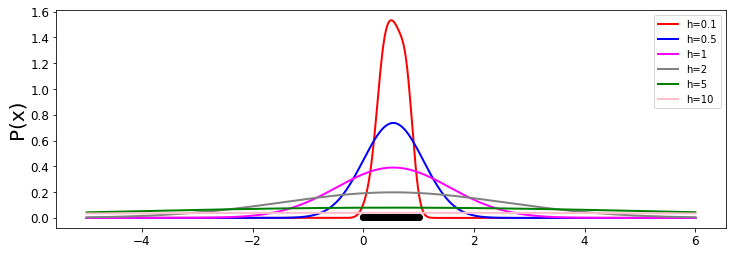

In [ ]:
color = ['red','blue','magenta','gray','green','pink']

X = x_scaled[:,0].reshape((len(x_scaled),1))

x_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:,np.newaxis]
plt.figure(figsize=(12,4))
plt.plot(X[:,0], 0.01*np.ones(X.shape[0]), 'ok')
c=0
vh = [0.1, 0.5, 1, 2, 5, 10]
for h in vh:
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X)
    log_dens = np.exp(kde.score_samples(x_plot))
    plt.plot(x_plot,log_dens, color= color[c], linewidth =2, label= 'h='+str(h))
    c = c+1
plt.ylabel('P(x)', fontsize=20)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend( fontsize=10)
plt.show(True)

In [ ]:
class ParzeWindowsClassifier:

    def __init__(self, h, kernel):
        a = None
        self.h = h
        self.kernel = kernel

    def fit(self, X_train, X_test , y_train):
        P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns=classes)
        #Chances de pertencer a cada classe
        Pc = np.zeros(len(classes))
        for i in np.arange(0, len(classes)):
            elements = tuple(np.where(y_train == classes[i])) #elementos na classe i
            Pc[i] = len(elements)/len(y_train) #probabilidade de pertencer a classe
            z = X_train[elements,:][0] # Elementos que pertencer a classe i no conjunto de treinamento
            kde = KernelDensity(kernel=self.kernel, bandwidth=self.h).fit(z)
            for j in np.arange(0, X_test.shape[0]):
                x = X_test[j,:]
                x = x.reshape((1,len(x)))
                #calcular a probabilidade de pertencer a cada classe
                pj = np.exp(kde.score_samples(x))
                P[classes[i]][j] = pj*pc[i]

        return P 
    def predict(self, X_test, prob):
        y_pred = []
        for i in np.arange(0, X_test.shape[0]):
            c = np.argmax(np.array(prob.iloc[[i]]))
            y_pred.append(classes[c])
        y_pred = np.array(y_pred)
        return y_pred

In [ ]:
#'epanechnikov', 'exponential', 'linear', 'tophat', 'cosine', 'gaussian'
parzen = ParzeWindowsClassifier(2, 'exponential')
mean_p, std_p, y_preds_p, scores_p, X_test_p, y_test_p, X_train_p, y_train_p = runModel2(parzen, N ,False, x_scaled,y ,10, 25)

Média de validação: 0.8928435417327831, desvio padrão:0.030116109969443566


In [ ]:
getMetrics(y_preds_p[0], y_test_p)

Precision: 0.8905109489051095, Recall: 0.8905109489051095, Erro: 0.10948905109489049, Support: None, F_Measure: 0.8905109489051094


In [ ]:
conf_int_p = scipy.stats.norm.interval(0.95, loc=np.mean(scores_p), scale=np.mean(std_p))
conf_int_p

(0.8338170508382261, 0.9518700326273402)

In [ ]:
y_test_p = np.array(y_test_p).reshape((1, len(y_test_p)))
y_test_p = np.array(y_test_p)
y_preds_p[0]= np.array([y_preds_p[0]])

In [ ]:
from sklearn.metrics import coverage_error
coverage_error(y_test_p, y_preds_p[0])

137.0

# Regressão Logística (IV)

Treine um classificador baseado em regressão logistica com os 4 atributos numericos x1, x2, x3, x4. v)

In [ ]:
lr = LogisticRegression(random_state=12, penalty='l2', C=2.0, solver='liblinear', max_iter=1500)
mean_lr, std_lr, y_preds_lr, scores_lr, X_test_lr, y_test_lr, X_train_lr, y_train_lr  = runModel(lr, N, False, x_scaled, y, 10, 15)

Média de validação: 0.9672008886067915, desvio padrão:0.012734396236088266


In [ ]:
getMetrics(y_preds_lr[0], y_test_lr)

Precision: 0.9781021897810219, Recall: 0.9781021897810219, Erro: 0.021897810218978075, Support: None, F_Measure: 0.9781021897810219


In [ ]:
conf_int_rl = scipy.stats.norm.interval(0.95, loc=np.mean(scores_lr), scale=np.mean(std_lr))
conf_int_rl

(0.9422419306191961, 0.9921598465943869)

In [ ]:
y_test_lr = np.array(y_test_lr).reshape((1, len(y_test_lr)))
y_test_lr = np.array(y_test_lr)
y_preds_lr[0]= np.array([y_preds_lr[0]])

In [ ]:
from sklearn.metrics import coverage_error
coverage_error(y_test_lr, y_preds_lr[0])

137.0

# Regressão Logística (V)
Treine um classificador baseado em regressão logistica com os 4 atributos numericos x1, x2, x3, x4 originais e mais 4 atributos suplementares x5 = x2
1 , x6 = x2, x7 = log(x3), x8 = 1 . Use regularização. √ x4 Use conjunto de validação para fixar o parâmetro de regularização.

In [ ]:
new_df = pd.DataFrame(x_scaled).copy()
min_max_scaler = preprocessing.StandardScaler()
new_df = min_max_scaler.fit_transform(new_df)
new_df = pd.DataFrame(new_df)
new_df

,0,1,2,3
0,1.121806,1.149455,-0.975970,0.354561
1,1.447066,1.064453,-0.895036,-0.128767
2,1.207810,-0.777352,0.122218,0.618073
3,1.063742,1.295478,-1.255397,-1.144029
4,-0.036772,-1.087038,0.736730,0.096587
...,...,...,...,...
1367,-0.009711,-0.097693,-0.660962,0.300996
1368,-0.641313,-1.158984,1.179023,0.730127
1369,-1.472357,-2.621646,3.759017,-0.754884
1370,-1.406693,-1.756471,2.552043,-0.043158


In [ ]:
#Cria novas outras colunas
new_df[4] = new_df[0] ** 2
new_df[5] = np.sqrt(new_df[1])
new_df[6] = np.log(new_df[2])
new_df[7] = (1/new_df[3])
new_df = pd.DataFrame(new_df)
new_df.fillna(0.00001, inplace=True)
new_df = np.array(new_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
min_max_scaler = preprocessing.StandardScaler()
x_scaled_2 = min_max_scaler.fit_transform(new_df)

In [ ]:
#'l1', 'l2', 'elasticnet'
lr2 = LogisticRegression(random_state=12, penalty='l2', C=2.0, solver='liblinear', max_iter=1500)
mean_lr2, std_lr2, y_preds_lr2, scores_lr2, X_test_lr2, y_test_lr2, X_train_lr2, y_train_lr2 = runModel(lr2, N, False, new_df, y, 10,15)


Média de validação: 0.9839574738178358, desvio padrão:0.010733502482067043


In [ ]:
getMetrics(y_preds_lr2[0], y_test_lr2)

Precision: 0.9927007299270073, Recall: 0.9927007299270073, Erro: 0.007299270072992692, Support: None, F_Measure: 0.9927007299270073


In [ ]:
conf_int_lr2 = scipy.stats.norm.interval(0.95, loc=np.mean(scores_lr2), scale=np.mean(std_lr2))
conf_int_lr2

(0.9629201955250132, 1.0049947521106586)

In [ ]:
y_test_lr2 = np.array(y_test_lr2).reshape((1, len(y_test_lr2)))
y_test_lr2 = np.array(y_test_lr2)
y_preds_lr2[0]= np.array([y_preds_lr2[0]])

In [ ]:
from sklearn.metrics import coverage_error
coverage_error(y_test_lr2, y_preds_lr2[0])


137.0

# Voto majoritario usando os classificadores i) a v) (VI)

Treine um classificador usando a regra do voto majoritario usando os classificadores i) a v)

In [ ]:
def ensemble_accuracy(pred_array, y_test):
    final_pred = np.array([])
    for i in range(len(y_test)):
        final_pred = np.append(final_pred, stats.mode([pred_array[0][i],
                                                       pred_array[1][i],
                                                       pred_array[2][i],
                                                       pred_array[3][i],
                                                       pred_array[4][i],                                                     
                                                      ])[0]
                              )
    return accuracy_score(y_test, final_pred)

In [ ]:
def ensembleClassifier():
    X_train_e, X_test_e, y_train_e, y_test_e  = train_test_split(x_scaled, y, test_size=0.2, train_size=0.8, stratify=y)
    X_train_el, X_test_el, y_train_el, y_test_el  = train_test_split(new_df, y, test_size=0.2, train_size=0.8, stratify=y)

    pred_array = []

    p1 = nb.fit(X_train_e, X_test_e, y_train_e)
    y_pred_nb = nb.predict(X_test_e, p1)
    pred_array.append(y_pred_nb)

    y_pred_knn = neigh.predict(X_test_e)
    pred_array.append(y_pred_knn)

    parzen = ParzeWindowsClassifier(2, 'epanechnikov')
    p2 = parzen.fit(X_train_e,X_test_e, y_train_e)
    y_pred_parzen = parzen.predict(X_test_e, p2)
    pred_array.append(y_pred_parzen)

    y_pred_lr = lr.predict(X_test_e)
    pred_array.append(y_pred_lr)

    y_pred_lr2 = lr2.predict(X_test_el)
    pred_array.append(y_pred_lr2)
    return ensemble_accuracy(pred_array, y_test_e) , pred_array, y_test_e

In [ ]:
mean_ensemble = []
for i in range(0,N):
    mean, pred_array_e, y_test_e = ensembleClassifier()
    mean_ensemble.append(mean)

mean_e = np.mean(mean_ensemble)
std_e = np.std(mean_ensemble)
print(f"Ensemble result: {mean_e}, {std_e}")


Ensemble result: 0.9795636363636363, 0.007829252204562367


In [ ]:
getMetrics(pred_array_e[0], y_test_e)

Precision: 0.9854545454545455, Recall: 0.9854545454545455, Erro: 0.014545454545454528, Support: None, F_Measure: 0.9854545454545455


In [ ]:
conf_int_p = scipy.stats.norm.interval(0.95, loc=np.mean(mean_ensemble), scale=np.mean(std_e))
conf_int_p

(0.9642185840168133, 0.9949086887104593)

In [ ]:
y_test_e = np.array(y_test_e).reshape((1, len(y_test_e)))
y_test_e = np.array(y_test_e)
pred_array_e[0]= np.array([pred_array_e[0]])

In [ ]:
from sklearn.metrics import coverage_error
coverage_error(y_test_e, pred_array_e[0])

126.0

c) Usar o Friedman test (teste não parametrico) para comparar os classificadores

In [ ]:
getFriedmanResult(scores_nb, scores_knn, scores_p, scores_lr, scores_lr2, mean_ensemble)

Statistics=228.6400000000001, p=2.0926075646437563e-47
A um nível de significância de 0.05, para P << 0.001 recomenda-se rejeitar H0


(228.6400000000001, 2.0926075646437563e-47)